In [23]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [25]:
file_path = r'C:\Users\81004\Desktop\F-F.dat'

In [27]:
data = np.loadtxt(file_path)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1. 定义高斯函数
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

def multi_gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        y += gaussian(x, params[i], params[i+1], params[i+2])
    return y


# 3. 自动估计初始参数（简单版）
def estimate_initial_parameters(x, y, n_peaks=2):
    # 这里实现一个简单的峰检测（实际应用可能需要更复杂的算法）
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(y, height=0.3*np.max(y))
    peaks = peaks[:n_peaks]  # 只取前n_peaks个峰
    
    initial_params = []
    for peak in peaks:
        amplitude = y[peak]
        mean = x[peak]
        # 估计半高宽
        half_max = amplitude / 2
        left_idx = np.where(y[:peak] <= half_max)[0]
        right_idx = np.where(y[peak:] <= half_max)[0]
        fwhm = (x[peak + right_idx[0]] - x[left_idx[-1]]) if (len(left_idx) > 0 and len(right_idx) > 0) else 1.0
        stddev = fwhm / 2.355  # 将FWHM转换为标准差
        initial_params.extend([amplitude, mean, stddev])
    
    return initial_params

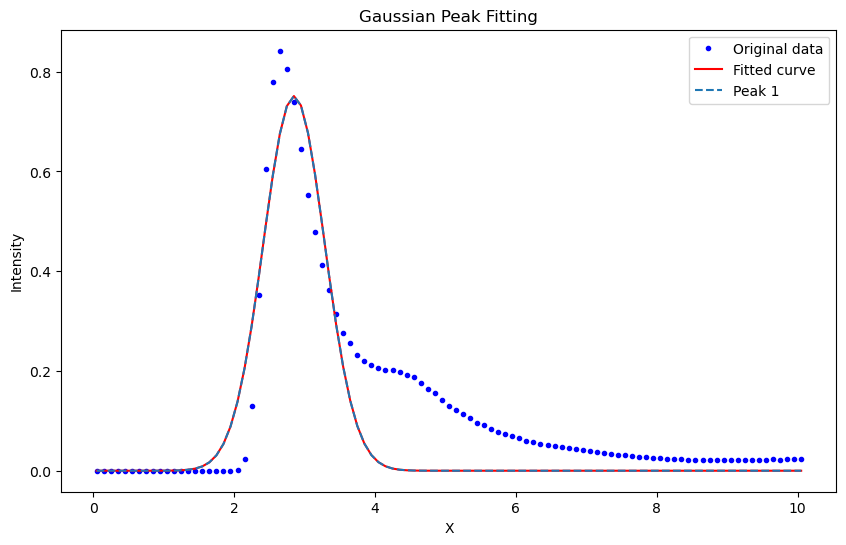

Fitted parameters:
Peak 1: Amplitude=0.7511, Center=2.8515, StdDev=0.4359


In [35]:
x = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])

# 4. 执行拟合（假设你想拟合2个峰）
n_peaks = 2  # 可以修改为你需要的峰数量
initial_guess = estimate_initial_parameters(x, y, n_peaks)

try:
    popt, pcov = curve_fit(multi_gaussian, x, y, p0=initial_guess)
    
    # 5. 计算拟合结果
    fit = multi_gaussian(x, *popt)
    
    # 6. 绘制结果
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b.', label='Original data')
    plt.plot(x, fit, 'r-', label='Fitted curve')
    
    # 绘制各个分峰
    for i in range(0, len(popt), 3):
        single_peak = gaussian(x, popt[i], popt[i+1], popt[i+2])
        plt.plot(x, single_peak, '--', label=f'Peak {i//3+1}')
    
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Intensity')
    plt.title('Gaussian Peak Fitting')
    plt.show()
    
    # 7. 打印拟合参数
    print("Fitted parameters:")
    for i in range(0, len(popt), 3):
        print(f"Peak {i//3+1}: Amplitude={popt[i]:.4f}, Center={popt[i+1]:.4f}, StdDev={popt[i+2]:.4f}")

except RuntimeError as e:
    print("拟合失败:", e)
    print("尝试调整初始参数或峰的数量")

D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25913 (\N{CJK UNIFIED IDEOGRAPH-6539}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Li

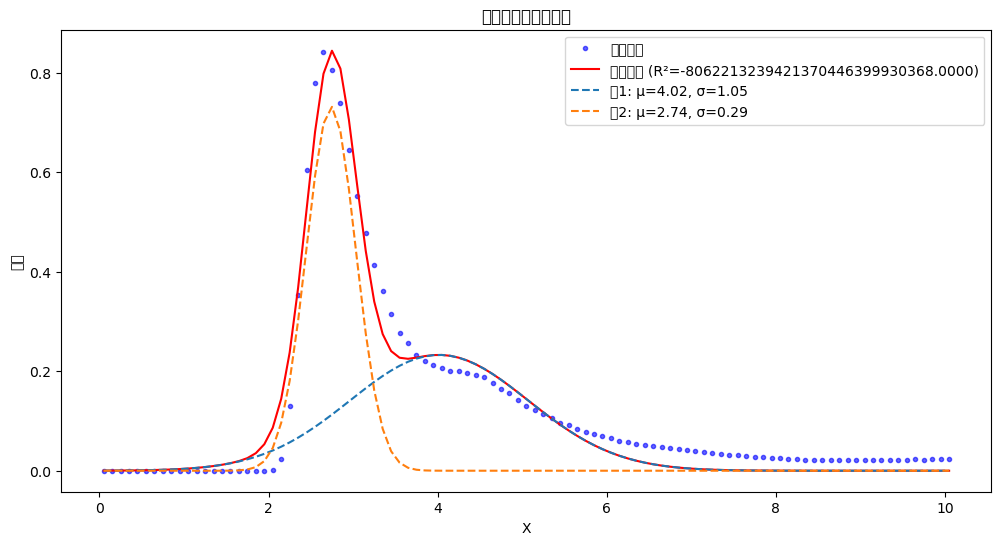


拟合参数:
峰1: 振幅=0.2327, 中心=4.0179, 标准差=1.0536
峰2: 振幅=0.7316, 中心=2.7404, 标准差=0.2932
拟合优度 R² = -8062213239421370446399930368.0000


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter
from sklearn.mixture import GaussianMixture

def gaussian(x, amplitude, mean, stddev):
    """高斯函数"""
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

def multi_gaussian(x, *params):
    """多高斯函数叠加"""
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        y += gaussian(x, params[i], params[i+1], params[i+2])
    return y

def estimate_baseline(y, window_size=51, polyorder=3):
    """估计并去除基线"""
    baseline = savgol_filter(y, window_size, polyorder)
    return y - baseline, baseline

def smart_peak_detection(x, y, n_peaks=2):
    """智能峰检测算法"""
    # 平滑处理
    smoothed = savgol_filter(y, 15, 3)
    
    # 自动确定高度阈值
    hist, bin_edges = np.histogram(y, bins=20)
    threshold = bin_edges[-3]  # 取较高的20%作为阈值
    
    # 找峰
    peaks, properties = find_peaks(smoothed, height=threshold, 
                                 prominence=(None,None), width=(None,None))
    
    # 按峰高排序并选择前n_peaks个
    if len(peaks) > 0:
        sorted_indices = np.argsort(properties['peak_heights'])[::-1]
        selected_peaks = peaks[sorted_indices[:min(n_peaks, len(peaks))]]
    else:
        # 如果没有找到峰，均匀分布初始猜测
        selected_peaks = np.linspace(x[0], x[-1], n_peaks+2)[1:-1].astype(int)
    
    return selected_peaks

def improved_initial_guess(x, y, n_peaks=2):
    """改进的初始参数估计"""
    # 基线校正
    y_corrected, _ = estimate_baseline(y)
    
    # 峰检测
    peaks = smart_peak_detection(x, y_corrected, n_peaks)
    
    initial_params = []
    for peak in peaks:
        amplitude = y_corrected[peak]
        mean = x[peak]
        
        # 计算半高宽
        half_max = amplitude / 2
        left_idx = np.where(y_corrected[:peak] <= half_max)[0]
        right_idx = np.where(y_corrected[peak:] <= half_max)[0]
        
        if len(left_idx) > 0 and len(right_idx) > 0:
            fwhm = x[peak + right_idx[0]] - x[left_idx[-1]]
            stddev = max(fwhm / 2.355, (x[1]-x[0])*2)  # 最小标准差设为2个点间距
        else:
            stddev = (x[-1] - x[0]) / (5 * n_peaks)
        
        initial_params.extend([amplitude, mean, stddev])
    
    # 如果峰不够，补充默认值
    while len(initial_params) < n_peaks * 3:
        default_amp = np.max(y_corrected) * 0.5
        default_mean = x[len(x) // (n_peaks + 1) * (len(initial_params)//3 + 1)]
        default_std = (x[-1] - x[0]) / (5 * n_peaks)
        initial_params.extend([default_amp, default_mean, default_std])
    
    return initial_params

def evaluate_fit(x, y, params):
    """评估拟合质量"""
    y_fit = multi_gaussian(x, *params)
    residuals = y - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y)))**2
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def robust_gaussian_fit(x, y, n_peaks=2, max_iter=3):
    """鲁棒的高斯拟合"""
    best_r2 = -np.inf
    best_params = None
    best_fit = None
    
    for _ in range(max_iter):
        try:
            # 获取初始猜测
            initial_guess = improved_initial_guess(x, y, n_peaks)
            
            # 设置合理的参数边界
            x_range = x[-1] - x[0]
            bounds = (
                [0, x[0], x_range/100] * n_peaks,  # 下界
                [np.inf, x[-1], x_range/2] * n_peaks  # 上界
            )
            
            # 执行拟合
            params, _ = curve_fit(multi_gaussian, x, y, p0=initial_guess,
                                bounds=bounds, maxfev=10000)
            
            # 评估拟合
            r2 = evaluate_fit(x, y, params)
            
            if r2 > best_r2:
                best_r2 = r2
                best_params = params
                best_fit = multi_gaussian(x, *params)
                
        except Exception as e:
            print(f"拟合尝试失败: {e}")
            continue
    
    return best_params, best_fit, best_r2

# 使用示例
if __name__ == "__main__":
    # 生成测试数据（替换为你的实际数据）
    x = np.array([i[0] for i in data])
    y = np.array([i[1] for i in data])
    
    n_peaks = 2
    params, fit, r2 = robust_gaussian_fit(x, y, n_peaks)
    
    # 绘制结果
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, 'b.', label='原始数据', alpha=0.6)
    plt.plot(x, fit, 'r-', label=f'拟合曲线 (R²={r2:.4f})')
    
    # 绘制各分峰
    for i in range(0, len(params), 3):
        peak = gaussian(x, params[i], params[i+1], params[i+2])
        plt.plot(x, peak, '--', label=f'峰{i//3+1}: μ={params[i+1]:.2f}, σ={params[i+2]:.2f}')
    
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('强度')
    plt.title('改进的高斯分峰拟合')
    plt.show()
    
    # 打印拟合参数
    print("\n拟合参数:")
    for i in range(0, len(params), 3):
        print(f"峰{i//3+1}: 振幅={params[i]:.4f}, 中心={params[i+1]:.4f}, 标准差={params[i+2]:.4f}")
    print(f"拟合优度 R² = {r2:.4f}")

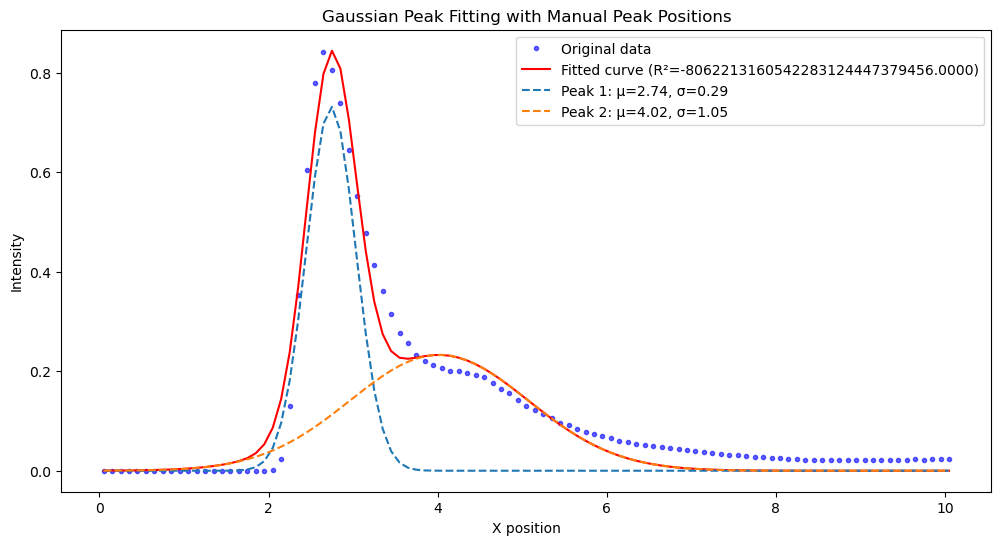


FITTING RESULTS
Peak  Amplitude   Center      StdDev      
1     0.7316      2.7404      0.2932      
2     0.2327      4.0179      1.0536      
Goodness of fit (R²): -8062213160542283124447379456.0000

Parameters saved to 'fitted_peaks_params.txt'


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

def gaussian(x, amplitude, mean, stddev):
    """高斯函数"""
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

def multi_gaussian(x, *params):
    """多高斯峰叠加"""
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        y += gaussian(x, params[i], params[i+1], params[i+2])
    return y

def manual_initial_guess(x, y, peak_positions):
    """根据指定峰位置生成初始参数"""
    initial_params = []
    for pos in peak_positions:
        # 找到最近的数据点索引
        idx = np.argmin(np.abs(x - pos))
        amplitude = y[idx]
        mean = x[idx]
        
        # 估计标准差 (使用经验值)
        stddev = (x[-1] - x[0]) / (10 * len(peak_positions))
        
        initial_params.extend([amplitude, mean, stddev])
    return initial_params

def evaluate_fit(x, y, params):
    """评估拟合质量"""
    y_fit = multi_gaussian(x, *params)
    residuals = y - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y)))**2
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def fit_peaks(x, y, peak_positions, maxfev=10000):
    """执行拟合"""
    # 生成初始猜测
    initial_guess = manual_initial_guess(x, y, peak_positions)
    
    # 设置参数边界
    x_range = x[-1] - x[0]
    lower_bounds = [0, x[0], x_range/100] * len(peak_positions)
    upper_bounds = [np.inf, x[-1], x_range/2] * len(peak_positions)
    bounds = (lower_bounds, upper_bounds)
    
    # 执行拟合
    params, _ = curve_fit(multi_gaussian, x, y, 
                         p0=initial_guess,
                         bounds=bounds,
                         maxfev=maxfev)
    
    # 计算拟合优度
    r2 = evaluate_fit(x, y, params)
    
    return params, r2

# 示例使用
if __name__ == "__main__":
    # 生成测试数据 (替换为你的实际数据)
    np.random.seed(43)
    x = np.array([i[0] for i in data])
    y = np.array([i[1] for i in data])
    
    # 用户指定参数
    peak_positions = [2.65, 6.0]  # 指定峰的大致中心位置
    n_peaks = len(peak_positions)
    
    # 执行拟合
    params, r2 = fit_peaks(x, y, peak_positions)
    
    # 计算拟合曲线
    y_fit = multi_gaussian(x, *params)
    
    # 绘制结果
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, 'b.', label='Original data', alpha=0.6)
    plt.plot(x, y_fit, 'r-', label=f'Fitted curve (R²={r2:.4f})')
    
    # 绘制各分峰
    for i in range(0, len(params), 3):
        peak = gaussian(x, params[i], params[i+1], params[i+2])
        plt.plot(x, peak, '--', label=f'Peak {i//3+1}: μ={params[i+1]:.2f}, σ={params[i+2]:.2f}')
    
    plt.legend()
    plt.xlabel('X position')
    plt.ylabel('Intensity')
    plt.title('Gaussian Peak Fitting with Manual Peak Positions')
    plt.show()
    
    # 打印拟合结果
    print("\nFITTING RESULTS")
    print("="*50)
    print(f"{'Peak':<6}{'Amplitude':<12}{'Center':<12}{'StdDev':<12}")
    for i in range(0, len(params), 3):
        print(f"{i//3+1:<6}{params[i]:<12.4f}{params[i+1]:<12.4f}{params[i+2]:<12.4f}")
    print("="*50)
    print(f"Goodness of fit (R²): {r2:.4f}")
    
    # 保存结果
    np.savetxt("fitted_peaks_params.txt", 
               params.reshape(-1, 3), 
               header="Amplitude Center StdDev",
               fmt="%.6f")
    print("\nParameters saved to 'fitted_peaks_params.txt'")